In [22]:
#連結雲端
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


透過簡單的預處理，嘗試理解資料內容與其所帶給後續分析的意義

In [23]:
import pandas as pd

# 讀取競標數據
df_bids = pd.read_csv('/content/drive/My Drive/bids.csv')
# 讀取訓練數據和測試數據
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
# Show the first few rows of the DataFrame
df_bids.head()


,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


1. 查看訓練數據的 outcome 欄位的分佈，用以瞭解正常使用者和機器人使用者的比例。

In [24]:
# Check the distribution of the 'outcome' column in the training set
df_train['outcome'].value_counts(normalize=True)


0.0    0.948833
1.0    0.051167
Name: outcome, dtype: float64

訓練集中的 outcome 欄位顯示，大約 94.9% 的競標者被標記為正常使用者（outcome 為 0），而約 5.1% 的競標者被標記為機器人（outcome 為 1）。這是一個不平衡的分類問題，我們在處理時需要注意。


2. 查看bids.csv中各項分布


In [25]:
# Check the distribution of the 'merchandise' column in the bids dataset
df_bids['merchandise'].value_counts(normalize=True)


mobile              0.277755
jewelry             0.248429
sporting goods      0.242310
home goods          0.159898
office equipment    0.037856
furniture           0.012954
computers           0.010590
books and music     0.006784
clothing            0.002148
auto parts          0.001274
Name: merchandise, dtype: float64

In [26]:
# Check the top 10 most common devices
common_devices = df_bids['device'].value_counts().head(10)

# Check the top 10 most common countries
common_countries = df_bids['country'].value_counts().head(10)

# Check the time range
time_min = df_bids['time'].min()
time_max = df_bids['time'].max()

common_devices, common_countries, time_min, time_max


(phone4      706573
 phone2      171584
 phone35     165230
 phone65     153855
 phone3      153202
 phone101    152048
 phone45     148388
 phone25     126426
 phone46     121215
 phone17     114389
 Name: device, dtype: int64,
 in    1788731
 ng     586586
 id     453611
 tr     319574
 us     318103
 za     297942
 ke     287962
 th     238172
 my     216799
 vn     190342
 Name: country, dtype: int64,
 9631916842105263,
 9772885210526315)

嘗試整理各項資料，將資料數字化為各項特徵值，並以圖表呈現


* num_bids_per_bidder：每個競標者的競標次數
* num_auctions_per_bidder：每個競標者參與的不同拍賣的數量
* num_devices_per_bidder：每個競標者使用的不同設備的數量
* num_merchandise_per_bidder：每個競標者競標的不同商品的數量
* num_countries_per_bidder：每個競標者來自的不同國家的數量


**嘗試創建上述的一些新的特徵，並將它們添加到了訓練集和測試集中。**









In [27]:
# Feature engineering
# Count the number of bids per bidder
num_bids_per_bidder = df_bids.groupby('bidder_id').size()
print(num_bids_per_bidder)
# Count the number of unique auctions per bidder
num_auctions_per_bidder = df_bids.groupby('bidder_id')['auction'].nunique()

# Count the number of unique devices per bidder
num_devices_per_bidder = df_bids.groupby('bidder_id')['device'].nunique()

# Count the number of unique merchandise per bidder

num_merchandise_per_bidder = df_bids.groupby('bidder_id')['merchandise'].nunique()
print(num_merchandise_per_bidder)
# Count the number of unique countries per bidder
num_countries_per_bidder = df_bids.groupby('bidder_id')['country'].nunique()

# Create a new DataFrame for the features
df_features = pd.DataFrame({
    'num_bids_per_bidder': num_bids_per_bidder,
    'num_auctions_per_bidder': num_auctions_per_bidder,
    'num_devices_per_bidder': num_devices_per_bidder,
    'num_merchandise_per_bidder': num_merchandise_per_bidder,
    'num_countries_per_bidder': num_countries_per_bidder,
})

# Reset the index of the DataFrame
df_features.reset_index(inplace=True)

# Merge the features with the training set
df_train = pd.merge(df_train, df_features, on='bidder_id', how='left')

# Merge the features with the test set
df_test = pd.merge(df_test, df_features, on='bidder_id', how='left')

df_train.head(), df_test.head()


bidder_id
001068c415025a009fee375a12cff4fcnht8y        1
002d229ffb247009810828f648afc2ef593rb        2
0030a2dd87ad2733e0873062e4f83954mkj86        1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o        3
00486a11dff552c4bd7696265724ff81yeo9v       20
                                         ...  
ffbc0fdfbf19a8a9116b68714138f2902cc13    25075
ffc4e2dd2cc08249f299cab46ecbfacfobmr3       22
ffd29eb307a4c54610dd2d3d212bf3bagmmpl        1
ffd62646d600b759a985d45918bd6f0431vmz      664
fff2c070d8200e0a09150bd81452ce29ngcnv        1
Length: 6614, dtype: int64
bidder_id
001068c415025a009fee375a12cff4fcnht8y    1
002d229ffb247009810828f648afc2ef593rb    1
0030a2dd87ad2733e0873062e4f83954mkj86    1
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o    1
00486a11dff552c4bd7696265724ff81yeo9v    1
                                        ..
ffbc0fdfbf19a8a9116b68714138f2902cc13    1
ffc4e2dd2cc08249f299cab46ecbfacfobmr3    1
ffd29eb307a4c54610dd2d3d212bf3bagmmpl    1
ffd62646d600b759a985d45918bd6f0431vmz    1
fff2c0

(                               bidder_id  \
 0  91a3c57b13234af24875c56fb7e2b2f4rb56a   
 1  624f258b49e77713fc34034560f93fb3hu3jo   
 2  1c5f4fc669099bfbfac515cd26997bd12ruaj   
 3  4bee9aba2abda51bf43d639013d6efe12iycd   
 4  4ab12bc61c82ddd9c2d65e60555808acqgos1   
 
                          payment_account  \
 0  a3d2de7675556553a5f08e4c88d2c228754av   
 1  a3d2de7675556553a5f08e4c88d2c228v1sga   
 2  a3d2de7675556553a5f08e4c88d2c2280cybl   
 3  51d80e233f7b6a7dfdee484a3c120f3b2ita8   
 4  a3d2de7675556553a5f08e4c88d2c22857ddh   
 
                                  address  outcome  num_bids_per_bidder  \
 0  a3d2de7675556553a5f08e4c88d2c228vt0u4      0.0                 24.0   
 1  ae87054e5a97a8f840a3991d12611fdcrfbq3      0.0                  3.0   
 2  92520288b50f03907041887884ba49c0cl0pd      0.0                  4.0   
 3  4cb9717c8ad7e88a9a284989dd79b98dbevyi      0.0                  1.0   
 4  2a96c3ce94b3be921e0296097b88b56a7x1ji      0.0                155.0   
 
    

以圖表視覺化

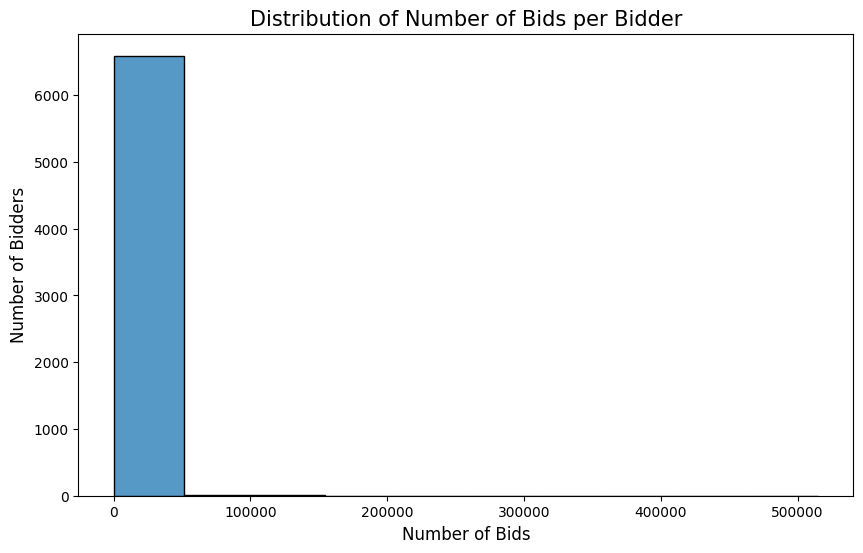

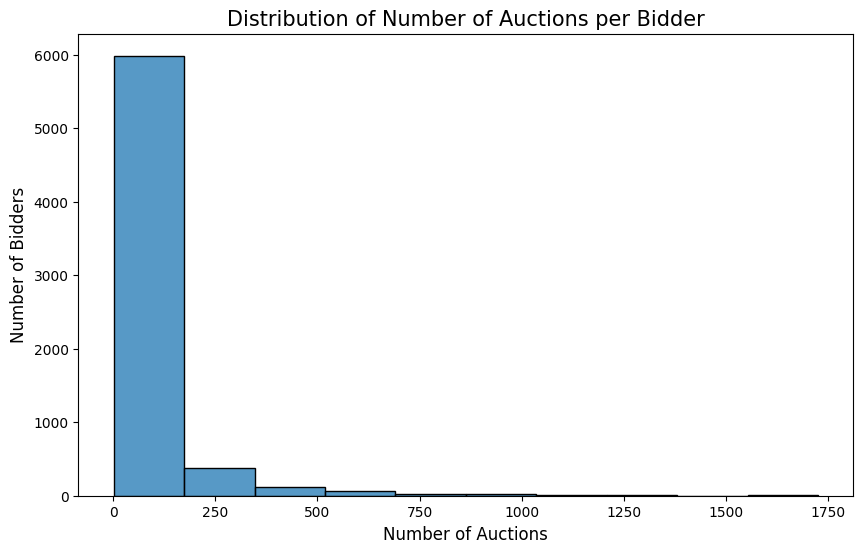

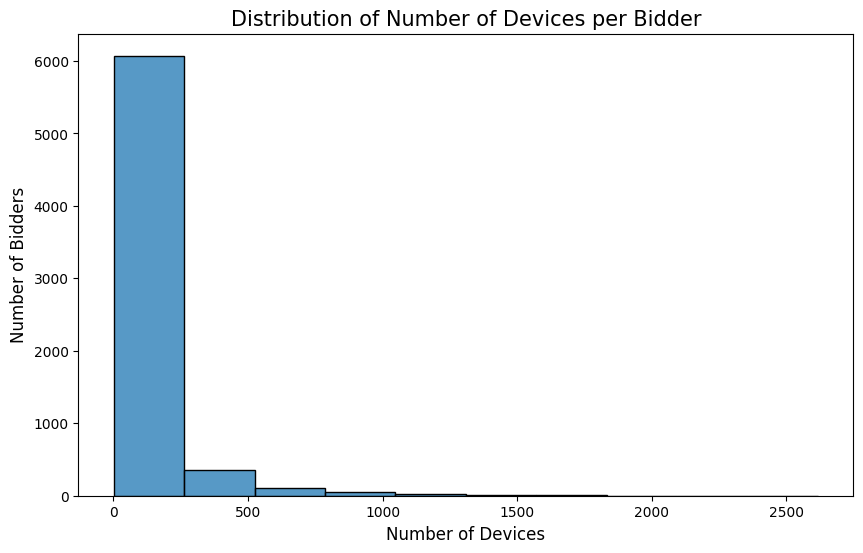

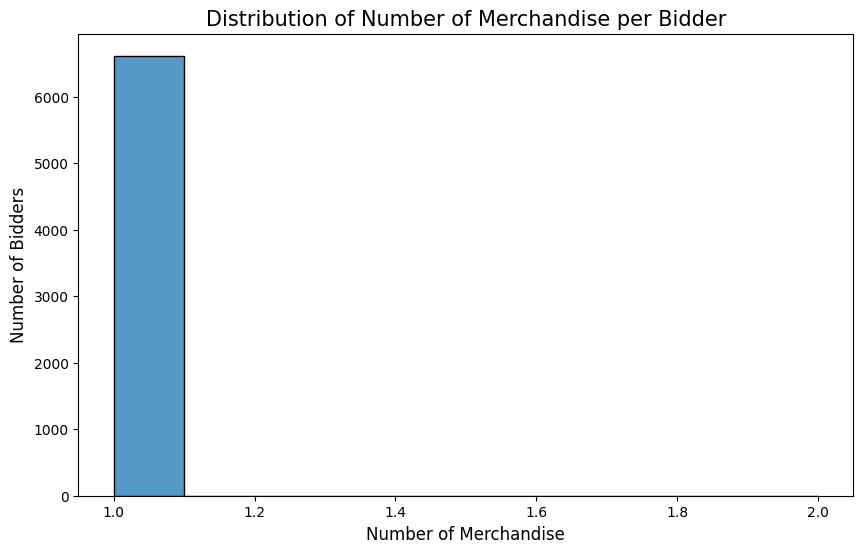

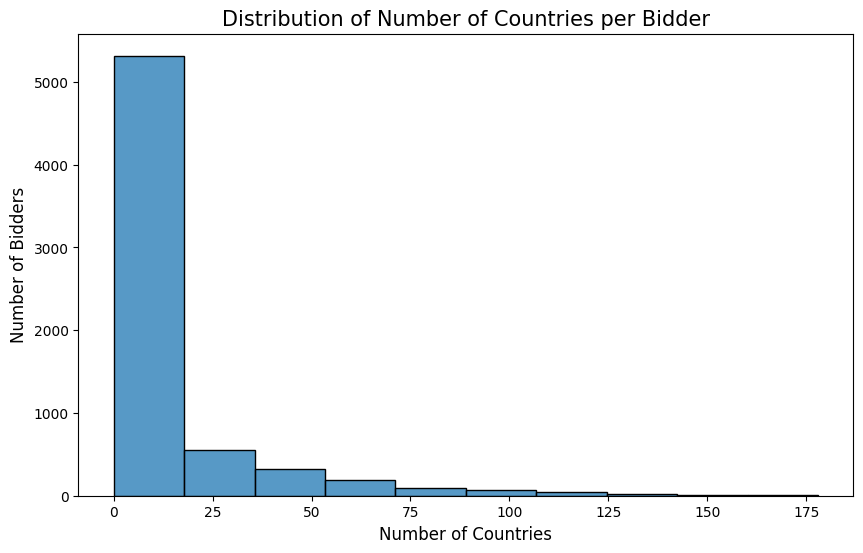

In [28]:

import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to plot the histograms
def plot_histogram(df, feature, title, xlabel, ylabel):
    plt.figure(figsize=(10,6))
    sns.histplot(df[feature], bins=10, kde=False)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()

# Plot the histograms for the features
plot_histogram(df_features, 'num_bids_per_bidder', 'Distribution of Number of Bids per Bidder', 'Number of Bids', 'Number of Bidders')
plot_histogram(df_features, 'num_auctions_per_bidder', 'Distribution of Number of Auctions per Bidder', 'Number of Auctions', 'Number of Bidders')
plot_histogram(df_features, 'num_devices_per_bidder', 'Distribution of Number of Devices per Bidder', 'Number of Devices', 'Number of Bidders')
plot_histogram(df_features, 'num_merchandise_per_bidder', 'Distribution of Number of Merchandise per Bidder', 'Number of Merchandise', 'Number of Bidders')
plot_histogram(df_features, 'num_countries_per_bidder', 'Distribution of Number of Countries per Bidder', 'Number of Countries', 'Number of Bidders')


**以上這些圖都顯示了競標者的行為具有很大的變異性，代表這可能對我們的機器學習模型的訓練有很大的幫助。**






處理可能存在的缺失值。我們可以將缺失值填充為 0，因為這些特徵的缺失可能意味著競標者在競標數據集中沒有記錄，也就是說他們的競標次數、參與的拍賣數量等都為 0

In [29]:
# Fill missing values with 0
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# Check the training set
df_train.head()


,bidder_id,payment_account,address,outcome,num_bids_per_bidder,num_auctions_per_bidder,num_devices_per_bidder,num_merchandise_per_bidder,num_countries_per_bidder
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,18.0,14.0,1.0,6.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,1.0,2.0,1.0,1.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,4.0,2.0,1.0,1.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,23.0,53.0,1.0,2.0


在這裡，我們將選擇一個相對簡單的模型，即**隨機森林（Random Forest）**。隨機森林是一種集成學習方法，它結合了多個決策樹的預測結果來提高預測的準確性和穩定性。同時，隨機森林也能夠處理分類問題和回歸問題，並且可以處理高維度和缺失數據，適合用於我們的任務。

我們首先將訓練集分為特徵（X）和目標變數（y），然後使用隨機森林模型來訓練數據。

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create the features (X) and target variable (y)
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)



In [31]:
# Train the model on the whole training set
model.fit(X_train, y_train)

# Create the features for the test set
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# Predict the probabilities for the test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Create a submission DataFrame
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# Write the submission DataFrame to a CSV file
df_submission.to_csv('S_test.csv', index=False)

df_submission.head()


,bidder_id,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,0.00
1,a921612b85a1494456e74c09393ccb65ylp4y,0.00
2,6b601e72a4d264dab9ace9d7b229b47479v6i,0.00
3,eaf0ed0afc9689779417274b4791726cn5udi,0.03
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,0.00


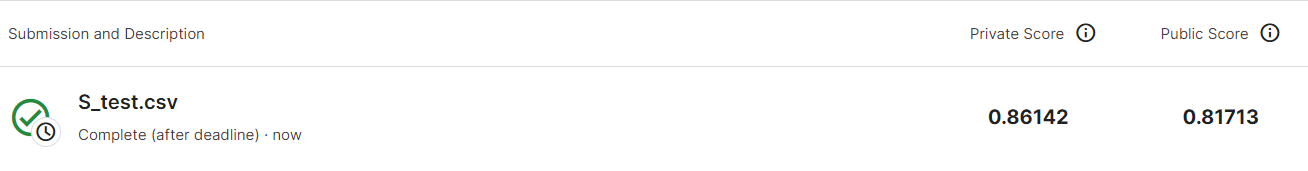

為了改善我們的模型，我們可能需要創建更具區分性的特徵。例如，我們可以考慮使用以下特徵：

* 每個競標者在短時間內的競標頻率。機器人可能會在短時間內進行大量的競標，而正常使用者的競標行為可能會更加分散。
* 每個競標者的競標時間模式。機器人可能全天24小時進行競標，而正常使用者可能只在特定的時間進行競標。
* 每個競標者使用的設備、IP 地址和網址的獨特性。機器人可能只使用一小部分的設備、IP 地址和網址，而正常使用者可能會使用更多的設備、IP 地址和網址。





In [32]:
# Calculate the number of bids made by each bidder per unit of time
df_bids['time'] = df_bids['time'].astype(float)
df_bids['time'] = (df_bids['time'] - df_bids['time'].min()) / (10**9 * 3600 * 24)  # convert to days
bids_per_day = df_bids.groupby('bidder_id')['time'].count() / (df_bids.groupby('bidder_id')['time'].max() - df_bids.groupby('bidder_id')['time'].min())

# Calculate the proportion of bids made by each bidder during typical bot hours (midnight to 6am)
df_bids['hour'] = (df_bids['time'] % 1) * 24
bids_during_bot_hours = df_bids[df_bids['hour'] < 6].groupby('bidder_id')['time'].count() / df_bids.groupby('bidder_id')['time'].count()

# Calculate the proportion of unique IPs, devices and URLs used by each bidder
unique_ips = df_bids.groupby('bidder_id')['ip'].nunique() / df_bids.groupby('bidder_id')['ip'].count()
unique_devices = df_bids.groupby('bidder_id')['device'].nunique() / df_bids.groupby('bidder_id')['device'].count()
unique_urls = df_bids.groupby('bidder_id')['url'].nunique() / df_bids.groupby('bidder_id')['url'].count()

# Add these new features to the DataFrame
df_features['bids_per_day'] = bids_per_day
df_features['bids_during_bot_hours'] = bids_during_bot_hours.fillna(0)
df_features['unique_ips'] = unique_ips
df_features['unique_devices'] = unique_devices
df_features['unique_urls'] = unique_urls

# Merge the new features with the training set
df_train = pd.merge(df_train, df_features, on='bidder_id', how='left')

# Merge the new features with the test set
df_test = pd.merge(df_test, df_features, on='bidder_id', how='left')

df_train.head(), df_test.head()


(                               bidder_id  \
 0  91a3c57b13234af24875c56fb7e2b2f4rb56a   
 1  624f258b49e77713fc34034560f93fb3hu3jo   
 2  1c5f4fc669099bfbfac515cd26997bd12ruaj   
 3  4bee9aba2abda51bf43d639013d6efe12iycd   
 4  4ab12bc61c82ddd9c2d65e60555808acqgos1   
 
                          payment_account  \
 0  a3d2de7675556553a5f08e4c88d2c228754av   
 1  a3d2de7675556553a5f08e4c88d2c228v1sga   
 2  a3d2de7675556553a5f08e4c88d2c2280cybl   
 3  51d80e233f7b6a7dfdee484a3c120f3b2ita8   
 4  a3d2de7675556553a5f08e4c88d2c22857ddh   
 
                                  address  outcome  num_bids_per_bidder_x  \
 0  a3d2de7675556553a5f08e4c88d2c228vt0u4      0.0                   24.0   
 1  ae87054e5a97a8f840a3991d12611fdcrfbq3      0.0                    3.0   
 2  92520288b50f03907041887884ba49c0cl0pd      0.0                    4.0   
 3  4cb9717c8ad7e88a9a284989dd79b98dbevyi      0.0                    1.0   
 4  2a96c3ce94b3be921e0296097b88b56a7x1ji      0.0                  155

我們已經創建了一些新的特徵並將它們加入到了訓練集和測試集中。這些新的特徵包括：

* bids_per_day：每個競標者每天的競標次數
* bids_during_bot_hours：每個競標者在典型的機器人活躍時間（午夜到早晨6點）內的競標次數佔其總競標次數的比例
* unique_ips：每個競標者使用的唯一 IP 地址數量佔其總競標次數的比例
* unique_devices：每個競標者使用的唯一設備數量佔其總競標次數的比例
* unique_urls：每個競標者訪問的唯一 URL 數量佔其總競標次數的比例

再次使用RandomForest模型來訓練數據，並對測試集進行預測

In [33]:
# Fill missing values with 0 again
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# Create the features (X) and target variable (y) again
X_train = df_train.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'])
y_train = df_train['outcome']


In [34]:
# Train the model on the whole training set again
model.fit(X_train, y_train)

# Create the features for the test set again
X_test = df_test.drop(columns=['bidder_id', 'payment_account', 'address'])

# Predict the probabilities for the test set again
y_test_proba = model.predict_proba(X_test)[:, 1]

# Create a submission DataFrame again
df_submission = df_test[['bidder_id']].copy()
df_submission['prediction'] = y_test_proba

# Write the submission DataFrame to a CSV file again
df_submission.to_csv('S_test2.csv', index=False)

df_submission.head()


,bidder_id,prediction
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,0.00
1,a921612b85a1494456e74c09393ccb65ylp4y,0.00
2,6b601e72a4d264dab9ace9d7b229b47479v6i,0.00
3,eaf0ed0afc9689779417274b4791726cn5udi,0.01
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,0.00


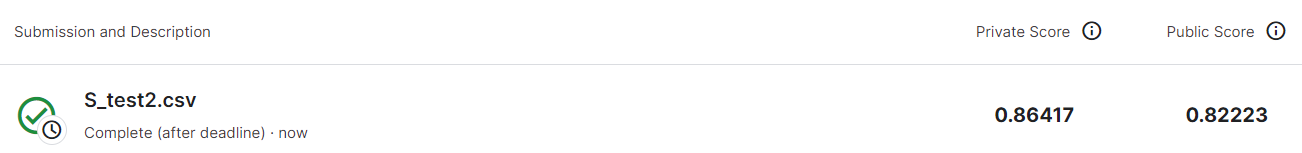

可以觀察到在加入新的特徵後，預測效果有些微的提升